In [2]:
import os
import sys
import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# Configuración de rutas para importar módulos locales
project_root = os.path.dirname(os.getcwd())
scripts_dir = os.path.join(project_root, "src", "scripts")
raw_data_inei = os.path.join(project_root, "data", "01_raw", "inei")
sys.path.insert(0, scripts_dir)

# 4. Local Application Imports
from getting_modules import EndesProcessor
from merging_data import JoinProcessor

from modeler_helper import (
    calcular_distancia,
    preparar_datos_bajo_peso,
    _basic_metrics,
    train_bajo_peso,

)



## Cargamos la data de Ubigeo para extrear variables socioeconómicas y geográficas 

### para luego calcular distancias del hogar hacia la capital de la provincia.

In [3]:
df_ubigeo = pd.read_csv(raw_data_inei + "\\geo\\ubigeo_provincia.csv", dtype={"inei": str})
df_ubigeo = df_ubigeo[
    [
        "inei",
        "departamento",
        "macroregion_inei",
        "pob_densidad_2020",
        "latitude",
        "longitude",
        "indice_densidad_estado",
        "indice_vulnerabilidad_alimentaria",
        "idh_2019",
        "pct_pobreza_total",
        "pct_pobreza_extrema",
    ]
]
df_ubigeo.rename(columns={"inei": "ubigeo_prov"}, inplace=True)

## Se extrea información importante de cada módulo de ENDES

In [4]:
rutas_modulos_23 = [
    "910-Modulo1629",
    "910-Modulo1630",
    "910-Modulo1631",
    "910-Modulo1632",
    "910-Modulo1633",
    "910-Modulo1634",
    "910-Modulo1635",
    "910-Modulo1636",
    "910-Modulo1637",
    "910-Modulo1638",
    "910-Modulo1639",
    "910-Modulo1640",
    "910-Modulo1641",
]

rutas_modulos_24 = [
    "968-Modulo1629",
    "968-Modulo1630",
    "968-Modulo1631",
    "968-Modulo1632",
    "968-Modulo1633",
    "968-Modulo1634",
    "968-Modulo1635",
    "968-Modulo1636",
    "968-Modulo1637",
    "968-Modulo1638",
    "968-Modulo1639",
    "968-Modulo1640",
    "968-Modulo1641",
]


path_23 = raw_data_inei + "\\2023"
path_24 = raw_data_inei + "\\2024"


processor_23 = EndesProcessor(data_path=path_23, anio=2023)
processor_24 = EndesProcessor(data_path=path_24, anio=2024)


dfs_procesados_23 = {
    f"mod_{i + 1}": getattr(processor_23, f"procesar_modulo_{i + 1}")(
        os.path.join(path_23, rutas_modulos_23[i]), 2023
    )
    for i in range(len(rutas_modulos_23))
}

dfs_procesados_24 = {
    f"mod_{i + 1}": getattr(processor_24, f"procesar_modulo_{i + 1}")(
        os.path.join(path_24, rutas_modulos_24[i]), 2024
    )
    for i in range(len(rutas_modulos_23))
}

Iniciando el procesamiento del Módulo 1 (RECH0, RECH1, RECH4) para el año 2023...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar = df_hogar.applymap(lambda x: x.strip() if isinstance(x, str) else x)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:99: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_miembros = df_miembros.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Advertencia: No se pudo procesar RECH4. Razón: Usecols do not match columns, columns expected but not found: ['HHO']. Se continuará sin datos de seguros.
Uniendo dataframes del Módulo 1...
Proceso del Módulo 1 completado. DataFrame con 139278 filas y 15 columnas.
Iniciando el procesamiento del Módulo 2 (RECH23) para el año 2023...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2023\910-Modulo1630\RECH23_2023.csv...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:197: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar_caracteristicas = df_hogar_caracteristicas.applymap(


Proceso del Módulo 2 completado. DataFrame con 37486 filas y 16 columnas.
Iniciando el procesamiento del Módulo 3 (REC0111, REC91) para el año 2023...
Uniendo dataframes del Módulo 3...
Proceso del Módulo 3 completado. DataFrame con 38352 filas y 13 columnas.
Iniciando el reprocesamiento del Módulo 4 (RE223132, REC21) para el año 2023...
Uniendo dataframes del Módulo 4...
Proceso del Módulo 4 completado. DataFrame con 63593 filas y 11 columnas.
Iniciando el reprocesamiento del Módulo 5 (REC41, REC94) para el año 2023...
Módulo 5 reprocesado. DataFrame con 20840 filas y 12 columnas.
Iniciando el reprocesamiento del Módulo 6 para el año 2023...
Módulo 6 reprocesado. DataFrame con 23316 filas y 19 columnas.
Iniciando el procesamiento del Módulo 7 (RE516171) para el año 2023...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2023\910-Modulo1635\RE516171_2023.csv...
Módulo 7 procesado. DataFrame con 35657 filas y 11 columnas.
Iniciando el procesamiento final del 

e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar = df_hogar.applymap(lambda x: x.strip() if isinstance(x, str) else x)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:99: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_miembros = df_miembros.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Advertencia: No se pudo procesar RECH4. Razón: Usecols do not match columns, columns expected but not found: ['HHO']. Se continuará sin datos de seguros.
Uniendo dataframes del Módulo 1...
Proceso del Módulo 1 completado. DataFrame con 135045 filas y 15 columnas.
Iniciando el procesamiento del Módulo 2 (RECH23) para el año 2024...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2024\968-Modulo1630\RECH23_2024.csv...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:197: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar_caracteristicas = df_hogar_caracteristicas.applymap(


Proceso del Módulo 2 completado. DataFrame con 37390 filas y 16 columnas.
Iniciando el procesamiento del Módulo 3 (REC0111, REC91) para el año 2024...
Uniendo dataframes del Módulo 3...
Proceso del Módulo 3 completado. DataFrame con 37117 filas y 13 columnas.
Iniciando el reprocesamiento del Módulo 4 (RE223132, REC21) para el año 2024...
Uniendo dataframes del Módulo 4...
Proceso del Módulo 4 completado. DataFrame con 60693 filas y 11 columnas.
Iniciando el reprocesamiento del Módulo 5 (REC41, REC94) para el año 2024...
Módulo 5 reprocesado. DataFrame con 19751 filas y 12 columnas.
Iniciando el reprocesamiento del Módulo 6 para el año 2024...
Módulo 6 reprocesado. DataFrame con 21999 filas y 19 columnas.
Iniciando el procesamiento del Módulo 7 (RE516171) para el año 2024...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2024\968-Modulo1635\RE516171_2024.csv...
Módulo 7 procesado. DataFrame con 34252 filas y 11 columnas.
Iniciando el procesamiento final del 

## Se concantena la data de 2 años para tener mayor información y se hace un proceso de limpieza con la función 'combinar_modulos'

In [5]:
join_processor_23 = JoinProcessor(dfs_procesados_23, "2023")
join_processor_24 = JoinProcessor(dfs_procesados_24, "2024")

df_master = pd.concat(
    [
        join_processor_24.combinar_modulos(dfs_procesados_24, "2024"),
        join_processor_23.combinar_modulos(dfs_procesados_23, "2023"),
    ],
    ignore_index=True,
)


print("shape antes de eliminar duplicados: ", df_master.shape)
id_cols = {
    "id_hogar",
    "id_miembro_hogar",
    "id_cuestionario_mujer",
    "id_nacimiento",
    "ubigeo",
    "anio",
    "latitud",
    "longitud",
}
# Nos aseguramos de que existan en el DF
id_cols = [c for c in id_cols if c in df_master.columns]

df_sin_ids = df_master.drop(columns=id_cols, errors="ignore")
df_master = df_master.loc[~df_sin_ids.duplicated(keep="first")].reset_index(drop=True)
df_master["ubigeo_prov"] = df_master["ubigeo"].astype(str).str[:-2] + "00"
df_master = df_master.merge(df_ubigeo, how="inner", on="ubigeo_prov")

df_master.drop(columns="ubigeo_prov", inplace=True)
df_master["distance_km_capital_province"] = df_master.apply(calcular_distancia, axis=1)

print("shape después  de eliminar duplicados: ", df_master.shape)

Uniendo con datos de características del hogar (Módulo 2)...
Traduciendo códigos a valores descriptivos...
Uniendo con datos prenatales y de parto (Módulo 5)...

Unión con Módulo 5 y mapeo completados.
shape antes de eliminar duplicados:  (19751, 92)
shape después  de eliminar duplicados:  (19751, 92)
Uniendo con datos de características del hogar (Módulo 2)...
Traduciendo códigos a valores descriptivos...
Uniendo con datos prenatales y de parto (Módulo 5)...

Unión con Módulo 5 y mapeo completados.
shape antes de eliminar duplicados:  (20840, 92)
shape después  de eliminar duplicados:  (20840, 92)
shape antes de eliminar duplicados:  (40591, 92)
shape después  de eliminar duplicados:  (40591, 103)


In [6]:
df_master.head()

,id_cuestionario_mujer,id_nacimiento,sexo_bebe,bebe_esta_vivo,intervalo_nacimiento_anterior_meses,id_miembro_hogar,total_hijos_nacidos,edad_mujer_primer_parto,mujer_actualmente_embarazada,mujer_uso_anticonceptivo_alguna_vez,...,macroregion_inei,pob_densidad_2020,latitude,longitude,indice_densidad_estado,indice_vulnerabilidad_alimentaria,idh_2019,pct_pobreza_total,pct_pobreza_extrema,distance_km_capital_province
0,325503101 2,1,2,1,60,3,3,22,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
1,325504701 2,1,2,1,130,4,2,20,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
2,325505001 1,1,2,1,216,3,2,17,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
3,325508901 2,1,2,1,147,4,2,21,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
4,325509701 2,1,1,1,96,4,2,21,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599


## Se prepara los datos para el entrenamiento

In [7]:
# df_master es tu DataFrame original
X_train, X_test, y_train, y_test = preparar_datos_bajo_peso(df_master)

# Verifica tamaños y proporciones
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
print(X_train["anio"].value_counts(normalize=True))
print(X_test["anio"].value_counts(normalize=True))

e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\modeler_helper.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_procesar[col] = serie.fillna(relleno)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\modeler_helper.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_procesar[col] = serie.fillna(relleno)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\modeler_helper.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resu

Shape antes de eliminar duplicados: (40591, 84)
Shape después de eliminar duplicados: (40590, 84)
(28413, 82) (12177, 82)
bajo_peso
0    0.940027
1    0.059973
Name: proportion, dtype: float64 bajo_peso
0    0.940051
1    0.059949
Name: proportion, dtype: float64
anio
1    0.513427
0    0.486573
Name: proportion, dtype: float64
anio
1    0.513427
0    0.486573
Name: proportion, dtype: float64


## Se Entrena el modelo

In [8]:
drop_columns_model = [
    "anio",
    "peso_bebe_nacimiento_gr",
    "id_hogar",
    "id_miembro_hogar",
    "id_cuestionario_mujer",
    "id_nacimiento",
    "id_miembro_hogar",
    "ubigeo",
    "anio",
    "latitud",
    "longitud",
    "latitude",
    "longitude",
]

In [ ]:
# Ejecutar el entrenamiento robusto
best_model, best_thresh, cv_metrics = train_bajo_peso(
    X=X_train, y=y_train, drop_cols=drop_columns_model, random_state=42
)

#Evaluar el modelo final en el conjunto de Test (nunca visto)
test_prob = best_model.predict_proba(X_test.drop(columns=drop_columns_model))[:, 1]

# 2. Crea una copia de X_test para trabajar de forma segura
df_evaluation = X_test.copy()
df_evaluation["real"] = y_test
df_evaluation["probability"] = test_prob

test_columns = {'real','probability'} 
columns_to_df_final= [x for x in list(df_evaluation.columns)  if x not in test_columns]
df_evaluation= df_evaluation[['id_hogar', 'id_miembro_hogar', 'id_cuestionario_mujer', 'id_nacimiento',
                               'real','probability']].merge(df_master[columns_to_df_final])



print( f"El mejor umbral para clasificar el modelo es : {best_thresh}" )

print(f"\nModelo final retornado: {type(best_model.named_steps['clf']).__name__}")

## Gráficando los facotes más determinantes

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8848\1430810520.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['feature_label'] = top_features['feature'].map(feature_labels)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8848\1430810520.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


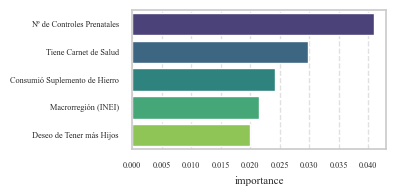

In [22]:
final_clf = best_model.named_steps["clf"]
feature_names = X_train.drop(columns=drop_columns_model).columns
if hasattr(final_clf, "feature_importances_"):
    importances = final_clf.feature_importances_
elif hasattr(final_clf, "coef_"):
    importances = np.abs(final_clf.coef_[0])
df_importance = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    "importance", ascending=False
)


sns.set_theme(style="whitegrid", palette="muted")


# --- Gráfico: Feature Importance ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
})

feature_labels = {
    'controles_prenatales_num': 'Nº de Controles Prenatales',
    'tiene_carnet_salud': 'Tiene Carnet de Salud',
    'consumio_suplemento_hierro_embarazo': 'Consumió Suplemento de Hierro',
    'macroregion_inei': 'Macrorregión (INEI)',
    'deseo_mas_hijos': 'Deseo de Tener más Hijos',
    'idioma_madre': 'Idioma Materno',
    'madre_afiliada_sis_embarazo': 'Madre Afiliada al SIS',
    'madre_peso_kg': 'Peso de la Madre (kg)',
    'tipo_servicio_higienico': 'Tipo de Servicio Higiénico',
    'decision_sobre_compras_grandes': 'Decisión sobre Compras Grandes'
}

top_features = df_importance.head(5)
top_features['feature_label'] = top_features['feature'].map(feature_labels)

fig, ax = plt.subplots(figsize=(4, 2))

sns.barplot(
    x="importance",
    y="feature_label",
    data=top_features,
    ax=ax,  
    palette="viridis",
    orient="h",
)

# --- 4. Títulos y Etiquetas Optimizados ---
#ax.set_title("Importancia de Características del Modelo", weight="bold")
#ax.set_xlabel("Nivel de Importancia (Gini Importance)")
ax.set_ylabel("")
ax.grid(axis='x', linestyle='--', alpha=0.6)


plt.tight_layout()
plt.savefig(project_root+"\\data\\03_reporting\\feature_importance.jpg", dpi=400, bbox_inches="tight")
plt.show()

## Guardando modelo y restultados

In [12]:
## guardando el mejor modelo
with open(project_root+'\\data\\02_model_output\\best_model.pkl', 'wb') as archivo_salida:
    pickle.dump(best_model, archivo_salida)


excel_path = project_root + '\\data\\03_reporting\\metricas_resultados.xlsx'


with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:

    cv_metrics.to_excel(writer, sheet_name='metricas_modelo', index=False)
    df_evaluation.to_excel(writer, sheet_name='datos_con_probabilidad', index=False)
    df_importance.to_excel(writer, sheet_name='importancia_variables', index=False)